# Read .doc file and clean the data and create a dataframe

In [1]:
from gender_predictor import GenderPredictor
gp = GenderPredictor()
gp.train_and_test()

import complete
32,031 male names
56,347 female names
classifier accuracy: 97.19%


In [3]:
import docx
import pprint
import pandas as pd
import requests
import json
import seaborn as sns
%matplotlib inline

#####################################################################
#gp = GenderPredictor()
#gp.train_and_test()
#########################################################################

file_name = 'Streetbook_2018-08-15.docx'
boston_street_zipcodes = 'boston_street_zipcodes.csv'

##################################################################################################

#list of words t obe removed from street names 
words_to_be_removed = ['Street',',', 'Road','Place','Square',';',
                          'Boulevard','Highway','Avenue','Alley', 'North', 'South', 'Mt.']
###################################################################################


def remove_duplicate_from_zipcode_list(zipcode_list):
    zipcodes = ""
    zipcode_list = zipcode_list.split("-")
    zipcode_list = list(set(zipcode_list))
    for zipcode in zipcode_list[:-1]:
        zipcodes += zipcode + "-" 
    zipcodes += zipcode_list[-1]  
    return zipcodes
###################################################################################

def clean_street_names(street_name, words_to_be_removed):
    for word in words_to_be_removed:
        street_name = street_name.replace(word, '')
    return street_name
##################################################################################

def create_request_url_string(first_name, last_name):
    prefix = 'https://api.namsor.com/onomastics/api/json/gender/'
    return prefix + first_name + '/' + last_name + '/us'

######################################################################################

def get_gender_namsor(street_name):
    first_name = 'null'
    last_name = 'null'
    splited_word = street_name.split()
    if len(splited_word) >= 1:
        first_name = splited_word[0]
    if len(splited_word) >= 2:
        last_name = splited_word[1]
    response = requests.get(create_request_url_string(first_name, last_name))
    response_json = response.json()
    #print(response.json())
    return response_json['gender']
#########################################################################################

#second api
def get_gender2(street_name):
    first_name = 'null'
    splited_word = street_name.split()
    if len(splited_word) >= 1:
        first_name = splited_word[0]
    gender = gp.classify(first_name)
    return gender

###############################################################################

def get_data_dict_from_file(filename):
    doc = docx.Document(filename)
    dataDict = {}
    rowIndex = 0
    street_name = ""
    for p in doc.paragraphs:
        #validating paragraphs
        if p.text != '' and len(p.text) > 5:
            for run in p.runs:
                run.text = run.text.strip()
                # if paragraph starts with a bold name, it means this is a new paragraph containing info about a new street
                if run.bold and run.text != "" and run.text != "*" and run.text != "Note;" and run.text != ".":
                    rowIndex += 1
                    street_name = clean_street_names(run.text, words_to_be_removed)
                    gender = get_gender_namsor(street_name)
                    gender2 = get_gender2(street_name)
                    dataDict[rowIndex] = {}
                    dataDict[rowIndex]['zipcodes'] =[]
                    dataDict[rowIndex]['fullname'] = run.text
                    dataDict[rowIndex]['streetname'] = street_name
                    dataDict[rowIndex]['name-length'] = len(street_name)
                    dataDict[rowIndex]['gender'] = gender
                    dataDict[rowIndex]['gender2'] = gender2
                    break
            #if constainsZipInfo:
            paragraph_words = p.text.split()
            #get last word as the zip code
            zipcode = paragraph_words[len(paragraph_words) - 1]
            if len(zipcode) > 5 : 
                zipcode = zipcode[-5:]
            dataDict[rowIndex]['zipcodes'].append(zipcode)
            #zipCodeDict[street_name].append(zipcode)
    return dataDict

####################################################################################################

def clean_data_dict(dataDict):
    for rowIndex_key, value in dataDict.items():
        zipcode_list = ""
        for elem in value['zipcodes'][:-1]:
            elem = elem.strip()
            if elem.isdigit():
                zipcode_list += elem + "-"
        if value['zipcodes'][-1].isdigit():
            zipcode_list += value['zipcodes'][-1]
        #based on the number of street segments with this name
        rank = len(zipcode_list.split("-"))
        zipcodes = remove_duplicate_from_zipcode_list(zipcode_list)
        dataDict[rowIndex_key] = [dataDict[rowIndex_key]['fullname'],
                                      dataDict[rowIndex_key]['streetname'],
                                      dataDict[rowIndex_key]['name-length'],
                                      dataDict[rowIndex_key]['gender'],
                                      dataDict[rowIndex_key]['gender2'],
                                      zipcodes, rank]
    return dataDict

#################################################################################

def create_data_df(filename):
    columns = columns=['full_name', 'street-name', 'name-length', 'gender','gender2','zipcodes','rank']
    dataDict = get_data_dict_from_file(filename)
    dataDict = clean_data_dict(dataDict)
    return pd.DataFrame.from_dict(dataDict, orient='index', columns=columns) 

#######################################################################################
 
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

############################################################################################

def get_zipcode_latitude_longitude_dataframe(fileName):
    return pd.read_csv(fileName,  converters={i: str for i in range(100)})

##########################################################################################


df = create_data_df(file_name)
zipcode_latitude_longitude_df = get_zipcode_latitude_longitude_dataframe(boston_street_zipcodes)
main_df_split_by_zipcode = splitDataFrameList(df,'zipcodes',"-")
main_df_merged_with_geo = main_df_split_by_zipcode.merge(zipcode_latitude_longitude_df, left_on='zipcodes', right_on='ZIP', how='inner')
main_df_merged_with_geo = main_df_merged_with_geo.sort_values(by=['full_name'])
main_df_merged_with_geo

,full_name,gender,gender2,name-length,rank,street-name,zipcodes,ZIP,LAT,LNG
0,"A Street,",unknown,F,2,1,A,02136,02136,42.255083,-71.129220
344,"A Street,",unknown,F,2,2,A,02210,02210,42.347472,-71.039271
405,"A Street,",unknown,F,2,2,A,02127,02127,42.334992,-71.039093
625,"Abbot Street,",male,M,6,2,Abbot,02124,02124,42.285805,-71.070571
1010,"Abbotsford Street,",unknown,M,11,1,Abbotsford,02121,02121,42.306267,-71.085897
1162,"Abby Road,",female,M,5,1,Abby,02135,02135,42.349688,-71.153964
1419,"Aberdeen Street,",female,M,9,1,Aberdeen,02215,02215,42.347635,-71.103082
1478,"Acacia Road,",female,F,7,1,Acacia,02132,02132,42.280455,-71.162017
1864,"Academic Way,",female,M,12,1,Academic Way,02134,02134,42.358016,-71.128608
2009,"Academy Court,",unknown,F,13,1,Academy Court,02119,02119,42.324029,-71.085017


# Combination of Both APIs Namsor and Gender Predictor Results

In [6]:
file_name = 'Streetbook_2018-08-15.docx'
words_to_be_removed = ['Street',',', 'Road','Place','Square',';',
                          'Boulevard','Highway','Avenue','Alley']

def get_data_dict_from_file(filename):
    doc = docx.Document(filename)
    dataDict = {}
    rowIndex = 0
    street_name = ""
    for p in doc.paragraphs:
        #validating paragraphs
        if p.text != '' and len(p.text) > 5:
            for run in p.runs:
                run.text = run.text.strip()
                # if paragraph starts with a bold name, it means this is a new paragraph containing info about a new street
                if run.bold and run.text != "" and run.text != "*" and run.text != "Note;" and run.text != ".":
                    rowIndex += 1
                    street_name = clean_street_names(run.text, words_to_be_removed)
                    gender = get_gender_namsor(street_name)
                    gender2 = get_gender2(street_name)
                    gender3 = 'neutral'
                    dataDict[rowIndex] = {}
                    dataDict[rowIndex]['zipcodes'] =[]
                    dataDict[rowIndex]['fullname'] = run.text
                    dataDict[rowIndex]['streetname'] = street_name
                    dataDict[rowIndex]['name-length'] = len(street_name)
                    if (gender == 'male' and gender2 == 'M') or (gender == 'female' and gender2 == 'F'):
                        dataDict[rowIndex]['gender'] = gender
                    else:
                        dataDict[rowIndex]['gender'] = gender3
                    break
            #if constainsZipInfo:
            paragraph_words = p.text.split()
            #get last word as the zip code
            zipcode = paragraph_words[len(paragraph_words) - 1]
            if len(zipcode) > 5 : 
                zipcode = zipcode[-5:]
            dataDict[rowIndex]['zipcodes'].append(zipcode)
            #zipCodeDict[street_name].append(zipcode)
    return dataDict

def clean_data_dict(dataDict):
    for rowIndex_key, value in dataDict.items():
        zipcode_list = ""
        for elem in value['zipcodes'][:-1]:
            elem = elem.strip()
            if elem.isdigit():
                zipcode_list += elem + "-"
        if value['zipcodes'][-1].isdigit():
            zipcode_list += value['zipcodes'][-1]
        #based on the number of street segments with this name
        rank = len(zipcode_list.split("-"))
        zipcodes = remove_duplicate_from_zipcode_list(zipcode_list)
        dataDict[rowIndex_key] = [dataDict[rowIndex_key]['fullname'],
                                      dataDict[rowIndex_key]['streetname'],
                                      dataDict[rowIndex_key]['name-length'],
                                      dataDict[rowIndex_key]['gender'],
                                      zipcodes, rank]
    return dataDict

def create_data_df(filename):
    columns = columns=['full_name', 'street-name', 'name-length', 'gender','zipcodes','rank']
    dataDict = get_data_dict_from_file(filename)
    dataDict = clean_data_dict(dataDict)
    return pd.DataFrame.from_dict(dataDict, orient='index', columns=columns)

combined = create_data_df(file_name)
combined

,full_name,street-name,name-length,gender,zipcodes,rank
1,"A Street,",A,2,neutral,02136,1
2,"A Street,",A,2,neutral,02210-02127,2
3,"Abbot Street,",Abbot,6,male,02124,2
4,"Abbotsford Street,",Abbotsford,11,neutral,02121,1
5,"Abby Road,",Abby,5,neutral,02135,1
6,"Aberdeen Street,",Aberdeen,9,neutral,02215,1
7,"Acacia Road,",Acacia,7,female,02132,1
8,"Academic Way,",Academic Way,12,neutral,02134,1
9,"Academy Court,",Academy Court,13,neutral,02119,1
10,"Academy Road,",Academy,8,neutral,02119,1


# Create the csv file from street-book

In [11]:
df.to_csv('output/street-book.csv')

# Show the distribution in a scatter plot
#### Size of cricles correponds to the size of the street which is infered from the number of segments in the original street map

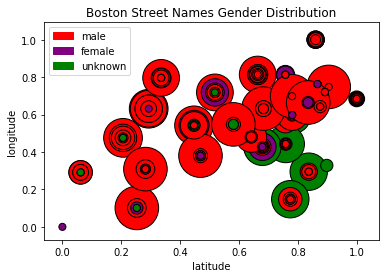

In [9]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings

#plt.style.use('ggplot')
min_max_scaler = preprocessing.MinMaxScaler()

def create_patches(colors, real_labels):
    """this function takes a list of colors and a list 
    of real names as the input. length of these two lists 
    must be the same.it create corresponding patches for plot legend
    """
    patches = []
    for i in range (0, len(real_labels)):
        patch = mpatches.Patch(color=colors[i], label= real_labels[i])
        patches.append(patch)
    return patches

data = main_df_merged_with_geo[['LAT','LNG','gender','gender2','rank']]
data['LAT'] = min_max_scaler.fit_transform(data['LAT'].values.reshape(-1,1))
data['LNG'] = min_max_scaler.fit_transform(data['LNG'].values.reshape(-1,1))

#data[["LAT", "LNG", "rank"]] = data[["LAT", "LNG","rank"]].apply(pd.to_numeric)
genders = data['gender']
colors = ['red','purple','green']
labels = []
for elem in data['gender'].tolist():
    if elem == 'male':
        labels.append('red')
    elif elem == 'female':
        labels.append('purple')
    elif elem == "unknown":
        labels.append('green')

colors = ("red", "purple", "green")
fig, ax = plt.subplots()
scatter_plt = ax.scatter(data['LAT'], data['LNG'], c=labels, cmap=matplotlib.colors.ListedColormap(colors), vmin=0, vmax=2,
                        edgecolor = 'black', s=data["rank"]*50)
#fig.set_size_inches(6.5, 6.5)
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_title('Boston Street Names Gender Distribution')
plt.legend(handles=create_patches(colors, ['male','female','unknown']))
plt.show()

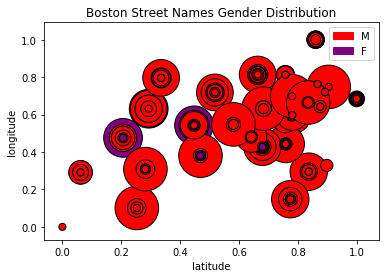

In [18]:
#data[["LAT", "LNG", "rank"]] = data[["LAT", "LNG","rank"]].apply(pd.to_numeric)
genders = data['gender2']
colors = ['red','purple']
labels = []
for elem in data['gender2'].tolist():
    if elem == 'M':
        labels.append('red')
    elif elem == 'F':
        labels.append('purple')

colors = ("red", "purple")
fig, ax = plt.subplots()
scatter_plt = ax.scatter(data['LAT'], data['LNG'], c=labels, cmap=matplotlib.colors.ListedColormap(colors), vmin=0, vmax=2,
                        edgecolor = 'black', s=data["rank"]*50)
#fig.set_size_inches(6.5, 6.5)
ax.set_xlabel('latitude')
ax.set_ylabel('longitude')
ax.set_title('Boston Street Names Gender Distribution')
plt.legend(handles=create_patches(colors, ['M','F']))
plt.show()

# Count total number of unknowns, male and female and plot bar

{'count': {'female': 994,
           'male': 3326,
           'unknown': 717}}


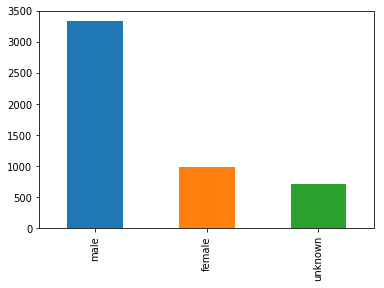

In [7]:
df['gender'].value_counts().plot(kind='bar')

def get_counts_for_gender(df):
    groupedByGender = df.groupby(['gender'], sort=False)['count'].sum().to_frame()
    return groupedByGender.to_dict()

df['count'] = 1
pprint.pprint(get_counts_for_gender(df), width=1)

groupedByStreetNames = df.groupby(['street-name'], sort=False)['count'].sum().to_frame()
groupedByStreetNames = groupedByStreetNames.sort_values('count', ascending=False)
groupedByStreetNames = groupedByStreetNames.merge(df, left_on='street-name', right_on='street-name')


{'count': {'F': 1129,
           'M': 3908}}


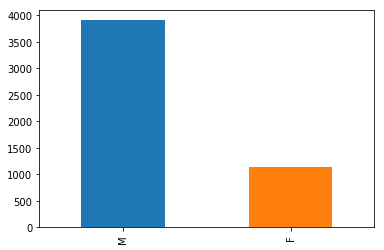

In [19]:
df['gender2'].value_counts().plot(kind='bar')

def get_counts_for_gender(df):
    groupedByGender = df.groupby(['gender2'], sort=False)['count'].sum().to_frame()
    return groupedByGender.to_dict()

df['count'] = 1
pprint.pprint(get_counts_for_gender(df), width=1)

 # Find the most repetetive names 

In [22]:
groupedByStreetNames = df.groupby(['street-name'], sort=False)['count'].sum().to_frame()
groupedByStreetNames = groupedByStreetNames.sort_values('count', ascending=False)
groupedByStreetNames.to_csv('street-name-frequency.csv')
groupedByStreetNames

,count
street-name,
Warren,10
Everett,10
Harvard,10
Chestnut,9
Webster,8
Franklin,8
Vernon,8
Cedar,7
Lexington,7


# Create csv file for male street names frequency 

In [34]:
male_names = df[df['gender'] == 'male']
male_names_frequency = male_names.groupby(['street-name'], sort=False)['count'].sum().to_frame()
male_names_frequency = male_names_frequency.sort_values('count', ascending=False)
male_names_frequency.to_csv('output/male-street-name-frequency.csv')

# Plot bar chart for 30 most repetttive names

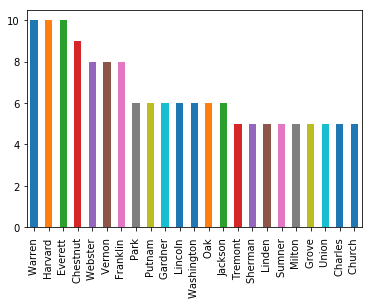

In [25]:
top_names = groupedByStreetNames.head(30)
top_names = df.merge(top_names, left_on='street-name', right_on='street-name')
top_male_names = top_names[top_names['gender'] == 'male']
top_male_names['street-name'].value_counts().plot(kind='bar')
plt.show()


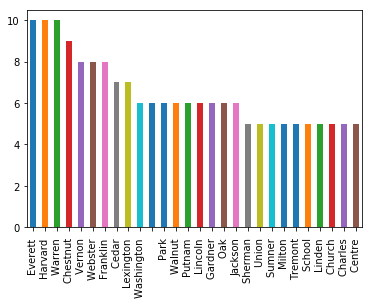

In [26]:
top_male_names = top_names[top_names['gender2'] == 'M']
top_male_names['street-name'].value_counts().plot(kind='bar')
plt.show()

In [27]:
top_male_names = top_male_names.sort_values(by=['count_y'], ascending=False)
top_male_names

,full_name,street-name,name-length,gender,gender2,zipcodes,rank,count_x,count_y
35,"Everett Square,",Everett,8,male,M,02136,1,1,10
60,"Harvard Avenue,",Harvard,8,male,M,02134,3,1,10
62,"Harvard Avenue,",Harvard,8,male,M,02136,2,1,10
168,"Warren Avenue,",Warren,7,male,M,02116,3,1,10
169,"Warren Avenue,",Warren,7,male,M,02129,1,1,10
31,"Everett Avenue,",Everett,8,male,M,02125,2,1,10
32,"Everett Place,",Everett,8,male,M,02128,1,1,10
33,"Everett Square,",Everett,8,male,M,02134,1,1,10
34,"Everett Square,",Everett,8,male,M,,1,1,10
36,"Everett Street,",Everett,8,male,M,02134-02135,4,1,10


[10, 10, 10, 9, 8, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5]


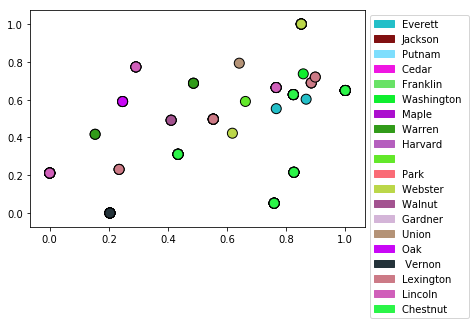

In [28]:
import random
number_of_colors = 20

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

top_twenty_names = groupedByStreetNames.head(20)
top_twenty_names.rename_axis("street-name")

label_map = {}
size_ranks = []
frequency = []
label = 0
for index, row in top_twenty_names.iterrows():
    row_name_splited = row.name.split(',')
    label_map[row_name_splited[0]]= label
    size_ranks.append(main_df_merged_with_geo[main_df_merged_with_geo['street-name'] == row.name])
    frequency.append(row['count'])
    label += 1
    
'''labels = []
for i in range(0,241):
    labels.append(i)
'''    
top_twenty_names = top_twenty_names.merge(main_df_merged_with_geo, left_on='street-name', right_on='street-name')
top_twenty_names['LAT'] = min_max_scaler.fit_transform(top_twenty_names['LAT'].values.reshape(-1,1))
top_twenty_names['LNG'] = min_max_scaler.fit_transform(top_twenty_names['LNG'].values.reshape(-1,1))

labels = []
for index, row in top_twenty_names.iterrows():
     labels.append(label_map[row['street-name']])


fig, ax = plt.subplots()
scatter_plt = ax.scatter(top_twenty_names['LAT'], top_twenty_names['LNG'], c=labels,cmap=matplotlib.colors.ListedColormap(colors), s=100, edgecolor = 'black')
plt.legend(handles=create_patches(colors, list(set(top_twenty_names['street-name']))), loc=2, bbox_to_anchor=(1, 1))
print(frequency)

# Find street candidates to be renamed
#### For renaming streets we need to consider a combination of factors like the global ferequency of the name across Boston erea, distribution rank which is defined by the number of clusters in which there streets with that name given a clustering factor, and concentration-rank which is the local frequency of the name in each cluster.
#### Other factors like size of the street are implictily considered in this approach given the fact that diffrent street sesgments for a name(with either or same zipcode) in the original datasets are considered as separate records in data set.


[[{'Baker ': 3}, {'Navarre ': 3}], [{'Harvard ': 5}, {' Vernon ': 5}], [{'Chestnut ': 4}, {'Columbus ': 4}], [{'Everett ': 3}, {'Lincoln ': 3}], [{'Dorchester ': 3}, {'Adams ': 2}]]


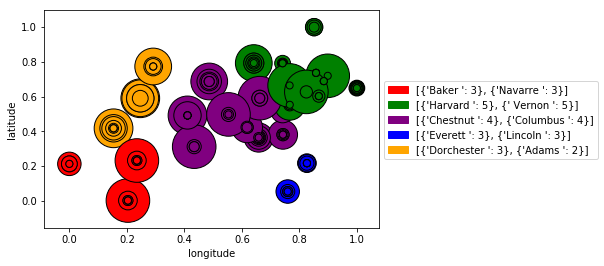

In [29]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import warnings
warnings.filterwarnings("ignore")


########################################################################################

def get_top_names_in_cluster(cluster_num, labels, dataframe):
    top_names = []
    count_dict = {}
    labels_index = 0
    for index, row in dataframe.iterrows():
        if labels[labels_index] == cluster_num:
            if row['street-name'] in count_dict:
                count_dict[row['street-name']] += 1
            else:
                count_dict[row['street-name']] = 1
        labels_index += 1
    sorted_count_dict = sorted(count_dict, key=count_dict.get, reverse=True)
    for elem in sorted_count_dict:
        value = {}
        value[elem] = count_dict[elem]
        top_names.append(value)
    return top_names

#######################################################################################

def get_real_labels_for_clusters(labels, dataframe, num_clusters, n):
    real_labels = []
    for i in range(0, num_clusters):
        top_cluster_names = get_top_names_in_cluster(i, labels, dataframe)
        real_labels.append(top_cluster_names[:n])
    return real_labels
    
#####################################################################################

min_max_scaler = preprocessing.MinMaxScaler()
#filter by gender 
main_df_merged_with_geo = main_df_merged_with_geo[main_df_merged_with_geo['gender'] == 'male']
geo_data = main_df_merged_with_geo[['LAT','LNG']]
geo_data['LAT'] = min_max_scaler.fit_transform(geo_data['LAT'].values.reshape(-1,1))
geo_data['LNG'] = min_max_scaler.fit_transform(geo_data['LNG'].values.reshape(-1,1))

latitude_list = geo_data['LAT'].tolist()
longitude_list = geo_data['LNG'].tolist()

vectors = []
for i in range(0,len(latitude_list)):
    vector = [latitude_list[i], longitude_list[i]]
    vectors.append(vector)
    
num_clusters = 5
kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
kmeans.fit_predict(vectors)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

 
real_labels = get_real_labels_for_clusters(labels, main_df_merged_with_geo, num_clusters, 2)
#real_labels = get_real_lables(labels, main_df_merged_with_geo, num_clusters, 1)
colors = ['red', 'green', 'purple', 'blue', 'orange']
print(real_labels)
plt.scatter(latitude_list, longitude_list, marker='o', c=labels, cmap=matplotlib.colors.ListedColormap(colors), s=main_df_merged_with_geo["rank"]*50, edgecolor='k')
plt.legend(handles=create_patches(colors, real_labels), bbox_to_anchor=(1, 0.7))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()


In [35]:
################################################################################################

def get_most_repetetive_names(dataframe, num_streets):
    dataframe['count'] = 1
    groupedByStreetNames = dataframe.groupby(['street-name'], sort=False)['count'].sum().to_frame()
    groupedByStreetNames = groupedByStreetNames.sort_values('count', ascending=False)
    #groupedByStreetNames = groupedByStreetNames.head(num_streets)
    count_dict = groupedByStreetNames.to_dict()
    return count_dict['count']

#####################################################################################################

def get_clusters_dict(cluster_labels, dataframe, count_dict):
    clusters_dict = {}
    labels_index = 0
    for index, row in main_df_merged_with_geo.iterrows():
        key = row['street-name']
        if key in clusters_dict:
            clusters_dict[key]['clusters-labels'].append(cluster_labels[labels_index])
            clusters_dict[key]['full-names'].append(row['full_name'])
        else:
            clusters_dict[key] = {}
            clusters_dict[key]['clusters-labels'] =[]
            clusters_dict[key]['clusters-labels'].append(cluster_labels[labels_index])
            clusters_dict[key]['full-names'] =[]
            clusters_dict[key]['full-names'].append(row['full_name'])
            clusters_dict[key]['gender'] = row['gender']
            clusters_dict[key]['global-frequency'] = count_dict[key]
            
        labels_index += 1 
    return clusters_dict

#######################################################################################################

def get_distribution_rank(clusters_dict, num_clusters):
    for street_name,clusters_labels in clusters_dict.items():
        clusters_dict[street_name]['distribution_rank'] = len(set(clusters_dict[street_name]['clusters-labels']))
        clusters_dict[street_name]['concentration_rank'] = get_max_clone_population(clusters_dict[street_name]['clusters-labels'], num_clusters)
    return clusters_dict

########################################################################################################

def get_max_clone_population(cluster_labels, num_clusters):
    clone_pop_dict = []
    for i in range(0, num_clusters):
        clone_pop_dict.append(0)
    for elem in cluster_labels:
        clone_pop_dict[elem] += 1
    return max(clone_pop_dict)

###########################################################################################################
count_dict = get_most_repetetive_names(df, 10)
clusters_dict = get_clusters_dict(labels, main_df_merged_with_geo, count_dict)
clusters_dict = get_distribution_rank(clusters_dict, num_clusters)
renaming_info_df = pd.DataFrame.from_dict(clusters_dict, orient='index')
renaming_info_df = renaming_info_df.sort_values(by=['concentration_rank','global-frequency'], ascending=[False,True])
renaming_info_df.to_csv('output/renaming_information_df.csv')
renaming_info_df

,clusters-labels,full-names,gender,global-frequency,distribution_rank,concentration_rank
Tremont,"[1, 3, 2, 3, 1, 1, 2, 1, 1]","[Tremont Place,, Tremont Place,, Tremont Stree...",male,5,3,5
Washington,"[1, 3, 0, 1, 0, 1, 2, 0, 2, 2, 4, 1, 2, 1]","[Washington Place,, Washington Street,, Washin...",male,6,5,5
Vernon,"[1, 1, 1, 1, 3, 0, 1, 2]","[Mt. Vernon Avenue,, Mt. Vernon Place,, Mt. Ve...",male,8,4,5
Harvard,"[2, 3, 0, 1, 0, 1, 1, 4, 1, 1, 4]","[Harvard Avenue,, Harvard Avenue,, Harvard Ave...",male,10,5,5
Congress,"[1, 1, 1, 1]","[Congress Street,, Congress Street,, Congress ...",male,1,1,4
Columbus,"[2, 1, 2, 2, 2]","[Columbus Avenue,, Columbus Avenue,, Columbus ...",male,2,2,4
Hanover,"[1, 1, 1, 1]","[Hanover Avenue,, Hanover Place,, Hanover Stre...",male,3,1,4
Webster,"[1, 1, 1, 0, 0, 0, 1]","[Webster Avenue,, Webster Place,, Webster Plac...",male,8,2,4
Chestnut,"[2, 2, 3, 0, 2, 0, 2, 1, 1]","[Chestnut Avenue,, Chestnut Place,, Chestnut P...",male,9,4,4
Warren,"[0, 1, 1, 2, 2, 1, 2, 2, 3, 1]","[Warren Avenue,, Warren Avenue,, Warren Avenue...",male,10,4,4
